<h1><strong><u>K-Nearest Neighbors Model</u></strong></h1>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, PrecisionRecallDisplay, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV, validation_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

<h2><u>Data Loading</u></h2>

In [2]:
df = pd.DataFrame(columns=["title", "target"])

In [3]:
# Formatting text files
titles = []
targets = []
file_path_dict = {'clickbait': './clickbait_data.txt', 'non clickbait': './non_clickbait_data.txt'}
for key, value in file_path_dict.items():
    with open(value, 'r') as file:
        for line_number, line in enumerate(file):
            line = line.strip()
            if line != "":
                titles.append(line)
                targets.append(key)
data_dict = {"title": titles, "target": targets}
df = pd.DataFrame(data_dict)


In [4]:
data = df.sample(frac=1, random_state=0).reset_index(drop=True)
display(data)

,title,target
0,UK guinea pig farm to close after owner's fami...,non clickbait
1,18 Sweet Pumpkin Treats You Won't Believe Are ...,clickbait
2,"A Guy Just Did The Most Epic ""Cha Cha Slide"" D...",clickbait
3,Premium gas discounted for a few hours,non clickbait
4,Sanctions on US products introduced by Brazil,non clickbait
...,...,...
31995,"Men, Stephen King Has A Really Important Messa...",clickbait
31996,Greek government faces censure motion by oppos...,non clickbait
31997,15 Holiday Cocktails That Are Basically Dessert,clickbait
31998,This Corgi And Baby Are Best Friends And It's ...,clickbait


In [5]:
X = data["title"]
y = data["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
display(X_train.shape) 
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(25600,)

(6400,)

(25600,)

(6400,)

In [6]:
def custom_tokenizer(text):
        from nltk.tokenize import word_tokenize
        from nltk.corpus import stopwords
        from nltk.stem import WordNetLemmatizer
        import re
        en_stopwords = stopwords.words('english')
        lemmatizer = WordNetLemmatizer()
        new_text = text.lower() #lowercase

        new_text = re.sub(r"([^\w\s])", "", new_text) #remove punctuation

        for word in new_text.split(): #remove stopwords
            if word in en_stopwords:
                new_text = new_text.replace(word, "")
        
        new_text = word_tokenize(new_text) #tokenize

        new_text = [lemmatizer.lemmatize(token) for token in new_text] #lemmatize
        return new_text

<h2><strong><u>KNN Model Selection</u></strong></h2>

<h3><u>Validation Curves</u></h3>

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END .................................clf__n_neighbors=1; total time= 1.2min
[CV] END ................................clf__n_neighbors=81; total time=  13.6s
[CV] END ................................clf__n_neighbors=51; total time= 1.4min
[CV] END ................................clf__n_neighbors=31; total time= 1.4min
[CV] END ................................clf__n_neighbors=71; total time= 1.4min
[CV] END ................................clf__n_neighbors=91; total time=  14.3s
[CV] END ................................clf__n_neighbors=11; total time= 1.4min
[CV] END ................................clf__n_neighbors=61; total time= 1.4min
[CV] END ................................clf__n_neighbors=21; total time= 1.4min
[CV] END ................................clf__n_neighbors=41; total time= 1.4min
[CV] END ...............................clf__n_neighbors=111; total time=  22.1s
[CV] END ...............................clf__n_neighbors=121; total time=  22.1s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  50 out of 100 | elapsed: 11.4min remaining: 11.4min


[CV] END ...............................clf__n_neighbors=101; total time=  11.4s
[CV] END ...............................clf__n_neighbors=111; total time=  18.7s
[CV] END ...............................clf__n_neighbors=141; total time=  22.9s
[CV] END ...............................clf__n_neighbors=131; total time=  26.0s
[CV] END ...............................clf__n_neighbors=121; total time=  18.6s
[CV] END ...............................clf__n_neighbors=171; total time=  26.3s
[CV] END ...............................clf__n_neighbors=151; total time=  26.4s
[CV] END ...............................clf__n_neighbors=161; total time=  25.9s
[CV] END ...............................clf__n_neighbors=181; total time=  22.9s
[CV] END .................................clf__n_neighbors=1; total time=  21.4s
[CV] END ................................clf__n_neighbors=11; total time=  23.0s
[CV] END ................................clf__n_neighbors=21; total time=  21.3s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 20.0min finished


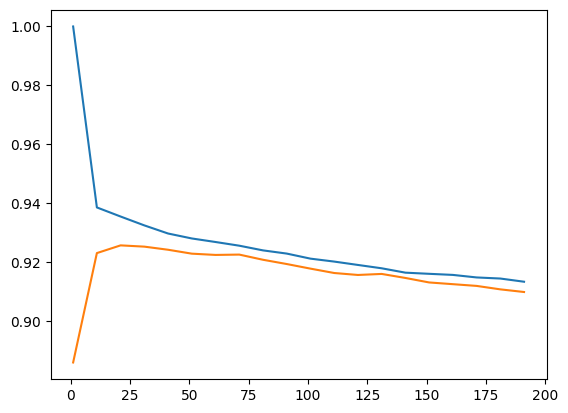

In [21]:
pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer(tokenizer=custom_tokenizer, token_pattern=None)),
        ("clf", KNeighborsClassifier())
    ]
)
neighbors = list(range(1, 201, 10))
train_scores, validation_scores = validation_curve(pipeline, X_train, y_train, cv=5, scoring='accuracy',
                                                   param_name="clf__n_neighbors",
                                                   param_range=neighbors,
                                                   verbose=2,
                                                   n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.plot(neighbors, train_scores_mean)
plt.plot(neighbors, validation_scores_mean)

<h3><u>Findings From 'Neighbor Count' Validation Curve</u></h3>
I chose to validate for a wide range of neighbors so that I could see the overall test/validation score trend with the increase of neighbors. It is pretty clear to see that 25 is the best neighbor count but for the CV test, I'll use a range from 20-30.

<h3><u>Cross Validation Testing</u></h3>

In [7]:
pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer(tokenizer=custom_tokenizer, token_pattern=None)),
        ("clf", KNeighborsClassifier())
    ]
)
param_grid = {
    "clf__n_neighbors": [23, 25, 27, 29],
}

model = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=3)
model.fit(X_train, y_train)
knn_classifier = model.best_estimator_
model.best_params_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 2/5] END ...............clf__n_neighbors=25;, score=0.926 total time=  13.0s
[CV 1/5] END ...............clf__n_neighbors=25;, score=0.924 total time=  13.1s
[CV 1/5] END ...............clf__n_neighbors=23;, score=0.923 total time=  13.1s
[CV 3/5] END ...............clf__n_neighbors=23;, score=0.924 total time=  13.2s
[CV 4/5] END ...............clf__n_neighbors=23;, score=0.922 total time=  16.0s
[CV 5/5] END ...............clf__n_neighbors=23;, score=0.929 total time=  16.0s
[CV 2/5] END ...............clf__n_neighbors=23;, score=0.928 total time=  16.0s
[CV 3/5] END ...............clf__n_neighbors=25;, score=0.927 total time=  16.1s
[CV 4/5] END ...............clf__n_neighbors=25;, score=0.921 total time=   8.2s
[CV 5/5] END ...............clf__n_neighbors=25;, score=0.928 total time=  12.2s
[CV 2/5] END ...............clf__n_neighbors=27;, score=0.926 total time=  12.1s
[CV 1/5] END ...............clf__n_neighbors=27;,

{'clf__n_neighbors': 23}

<h4><u>K-Nearest Neighbors Training Metrics</u></h4>

In [8]:
knn_training_values = cross_val_score(knn_classifier, X_train, y_train, scoring='accuracy', cv=5)
print(f"Cross-validation Accuracy training scores: ", knn_training_values)
np_knn_training_values = np.array(knn_training_values)
average = np.mean(np_knn_training_values)
stDev = np.std(np_knn_training_values)
print(average.round(2), " +/- ", stDev.round(4), "\n")

Cross-validation Accuracy training scores:  [0.9234375  0.92753906 0.92382812 0.92246094 0.92910156]
0.93  +/-  0.0026 



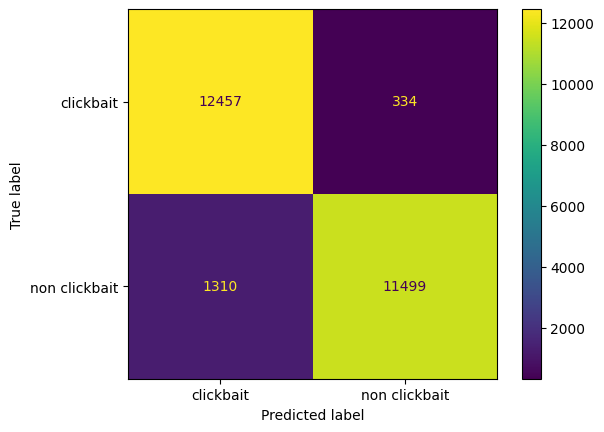

In [9]:
#Training Confusion Matrix
ConfusionMatrixDisplay.from_estimator(knn_classifier, X_train, y_train)

In [10]:
train_predictions = knn_classifier.predict(X_train)
tn, fp, fn, tp = confusion_matrix(y_train, train_predictions).ravel()
print("Precision Score", precision_score(y_train, train_predictions, pos_label='clickbait'))
print("Recall Score", recall_score(y_train, train_predictions, pos_label='clickbait'))
print("Negative Predictive Value Score", precision_score(y_train, train_predictions, pos_label='non clickbait'))
print("Specificity Score", recall_score(y_train, train_predictions, pos_label='non clickbait'))

Precision Score 0.9048449190092249
Recall Score 0.9738878899226018
Negative Predictive Value Score 0.9717738527845855
Specificity Score 0.897728159887579


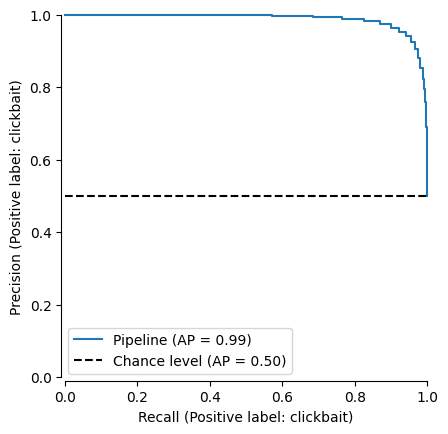

In [11]:
PrecisionRecallDisplay.from_estimator(knn_classifier, X_train, y_train, pos_label="clickbait", plot_chance_level=True, despine=True)

<h4><u>K-Nearest Neighbors Learning Curves</u></h4>

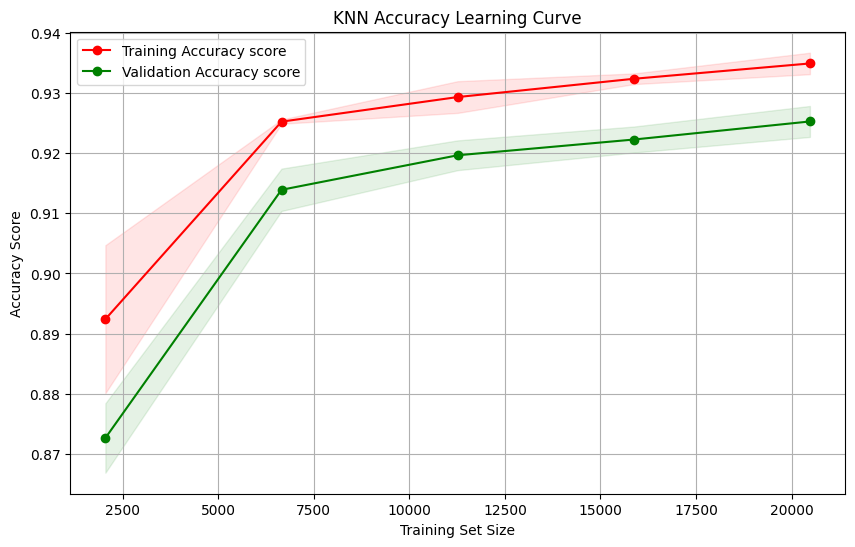

In [25]:
knn_train_sizes, knn_train_scores, knn_validation_scores = learning_curve(
    knn_classifier,
    X_train,
    y_train,
    cv=5,  # Number of folds for cross-validation
    scoring='accuracy',  # Metric to evaluate the model
    n_jobs=-1,  # Use all available CPU cores
)

# Calculate mean and standard deviation for scores
knn_train_scores_mean = np.mean(knn_train_scores, axis=1)
knn_train_scores_std = np.std(knn_train_scores, axis=1)
knn_validation_scores_mean = np.mean(knn_validation_scores, axis=1)
knn_validation_scores_std = np.std(knn_validation_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.title("KNN Accuracy Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.grid()

plt.fill_between(knn_train_sizes, knn_train_scores_mean - knn_train_scores_std,
                knn_train_scores_mean + knn_train_scores_std, alpha=0.1,
                color="r")
plt.fill_between(knn_train_sizes, knn_validation_scores_mean - knn_validation_scores_std,
                knn_validation_scores_mean + knn_validation_scores_std, alpha=0.1,
                color="g")
plt.plot(knn_train_sizes, knn_train_scores_mean, 'o-', color="r",
            label="Training Accuracy score")
plt.plot(knn_train_sizes, knn_validation_scores_mean, 'o-', color="g",
            label="Validation Accuracy score")

plt.legend(loc="best")
plt.show()

<h4><u>K-Nearest Neighbors Testing Metrics</u></h4>

In [26]:
knn_test_predictions = knn_classifier.predict(X_test)

knn_test_accuracy = accuracy_score(y_test, knn_test_predictions)
print("K-Nearest Neighbors Test Accuracy: {:.2f}%".format(knn_test_accuracy * 100))

K-Nearest Neighbors Test Accuracy: 92.62%


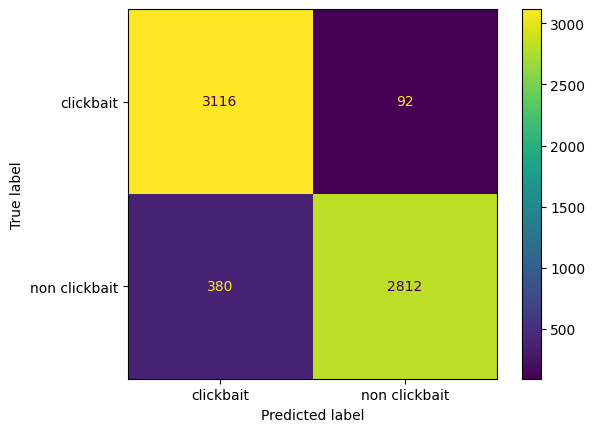

In [27]:
#Testing Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, knn_test_predictions)